In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys
from pathlib import Path

In [ ]:
files = [
    "../calibration radiometer 6 v3/data/T_hous_calibr.xlsx",
    "../calibration radiometer 8/data/T_Housing_Calibration.xlsx",
    "../calibration radiometer 10/data/T_Housing_Calibration.xlsx",
]
dates = [
    "19/08/25",
    "08/09/25",
    "08/09/25"
]
dfs_excel = []
radiometers = [6, 8, 10]
for i, f in enumerate(files):
    if not Path(f).exists():
        print(f"File {f} does not exist. Please check the path.")
    else:
        f = Path(f)
        df = pd.read_excel(f)
        df["condition"] = radiometers[i] 
        dfs_excel.append(df)
        print(f"File {f} loaded successfully with data {df.head()}.")



File ../calibration radiometer 6 v3/data/T_hous_calibr.xlsx loaded successfully with data    T_Housing  T_Plate  V_housing Condition  condition
0       26.5     25.0        778      open          6
1       29.3     29.2        807      open          6
2       31.5     31.4        829      open          6
3       33.6     33.6        850      open          6
4       36.7     36.7        882      open          6.
File ../calibration radiometer 8/data/T_Housing_Calibration.xlsx loaded successfully with data    T_Plate  T_Housing  V_housing  condition
0     24.5       24.5        755          8
1     28.3       27.0        786          8
2     27.9       27.9        795          8
3     31.0       30.7        823          8
4     33.5       33.9        855          8.
File ../calibration radiometer 10/data/T_Housing_Calibration.xlsx loaded successfully with data    T_Plate  T_Housing  V_housing  condition
0     23.0       25.2        767         10
1     29.8       28.2        800         

In [7]:
dff = pd.concat(dfs_excel, ignore_index=True)

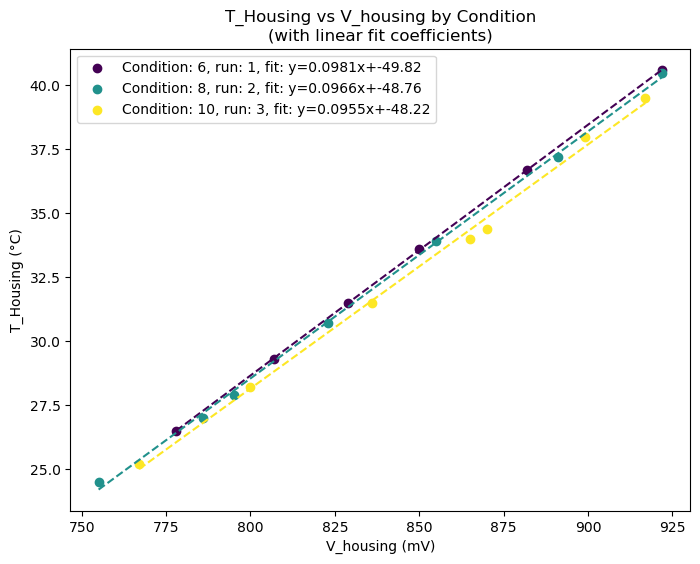

In [11]:
# Instead of conditions plot date, 

plt.figure(figsize=(8, 6))

unique_conditions = dff['condition'].unique()
colors = dict(zip(unique_conditions, plt.cm.viridis(np.linspace(0, 1, len(unique_conditions)))))

for i, condition in enumerate(unique_conditions):
    mask = dff['condition'] == condition
    x = dff.loc[mask, 'V_housing']
    y = dff.loc[mask, 'T_Housing']
    
    # Linear regression for this condition
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        slope = model.coef_[0]
        intercept = model.intercept_
        plt.scatter(x, y, label=f"Condition: {condition}, run: {i+1}, fit: y={slope:.3g}x+{intercept:.2f}", color=colors.get(condition, None))
        plt.plot(x, model.predict(x.values.reshape(-1, 1)), color=colors.get(condition, None), linestyle='--',
                 label=None)

plt.xlabel('V_housing (mV)')
plt.ylabel('T_Housing (°C)')
plt.legend(loc='upper left')
plt.title('T_Housing vs V_housing by Condition\n(with linear fit coefficients)')
plt.show()

In [12]:
# I will use a mean for HousingSlope and HousingOffset
HousingSlope = 0.096
HousingOffset = -48.9

def derive_t_housing_from_v_housing(v_housing):
    """
    Derive T_housing from V_housing using the OPEN condition linear regression.
    """
    return HousingSlope * v_housing + HousingOffset

In [22]:
paths = [
    "../calibration radiometer 6 v3/data/all_X.csv",
    "../calibration radiometer 8/data/all_X.csv",
    "../calibration radiometer 10/data/all_X.csv",
]
radiometers = ["Rad 6", "Rad 8", "Rad 10"]
Xs = []
for i, p in enumerate(paths):
    X = pd.read_csv(Path(p))
    X['radiometer'] = radiometers[i]
    X["V_rad"] = X["V_rad_tot"]
    Xs.append(X)

all_X = pd.concat(Xs, ignore_index=True)
print(all_X.radiometer.unique())
print(all_X.condition.unique())

all_X = all_X[~all_X['condition'].isin(['open', 'Open'])]
print(all_X.condition.unique())



['Rad 6' 'Rad 8' 'Rad 10']
['50C' 'Open' '25C' '50' 'open' '25']
['50C' '25C' '50' '25']


In [23]:
# Add temperature column: 25 if '25C' in condition, 50 if '50C' in condition
all_X['temperature'] = np.where(all_X['condition'].str.contains('25'), 25, 50)
print(all_X.temperature.unique())


[50 25]


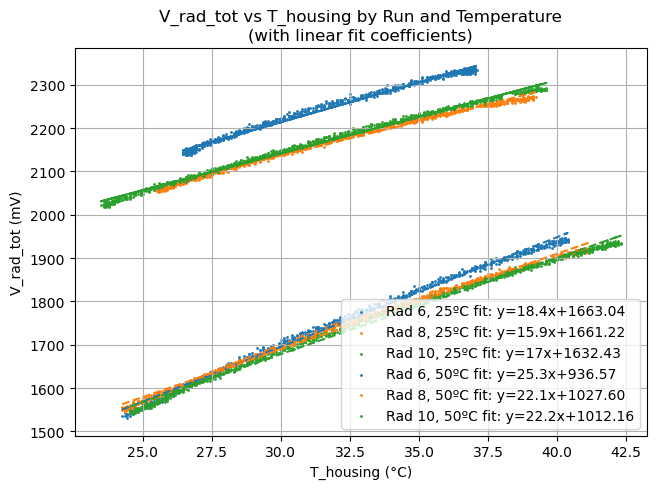

In [27]:
unique_runs = all_X['radiometer'].unique()
# Use a discrete colormap with more than 4 nice colors

# Example: tab10 has 10 distinct colors
cmap = plt.get_cmap('tab10')
colors = dict(zip(unique_runs, [cmap(i % 10) for i in range(len(unique_runs))]))

plt.figure(figsize=(8/1.2, 6/1.2))
for temp in [25, 50]:
    for run in unique_runs:

        subset = all_X[(all_X['radiometer'] == run) & (all_X['temperature'] == temp)]
        if subset.empty:
            continue
        T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
        
        
        x_curve = T_housing.values.reshape(-1, 1)
        y_curve = subset['V_rad_tot'].values
        if len(x_curve) > 1:
            model_curve = LinearRegression()
            model_curve.fit(x_curve, y_curve)
            slope_curve = model_curve.coef_[0]
            intercept_curve = model_curve.intercept_
            plt.plot(T_housing, model_curve.predict(x_curve), color=colors[run], linestyle='--')
        label = f"{run}, {temp}ºC fit: y={slope_curve:.3g}x+{intercept_curve:.2f}"
        plt.scatter(T_housing, subset['V_rad_tot'], label=label, color=colors[run], s=1)
plt.xlabel('T_housing (°C)')
plt.ylabel('V_rad_tot (mV)')
plt.title('V_rad_tot vs T_housing by Run and Temperature\n(with linear fit coefficients)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

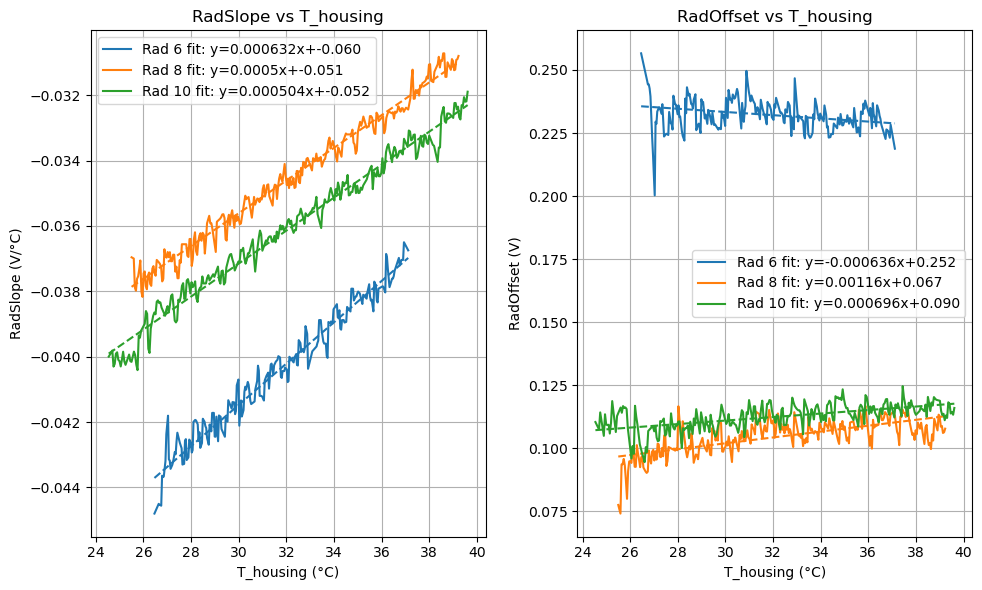

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

cmap = plt.get_cmap('tab10')
colors = dict(zip(unique_runs, [cmap(i % 10) for i in range(len(unique_runs))]))

for rad in unique_runs:
    # Select conditions for v1 and v2
    cond_25 = all_X[(all_X['radiometer'] == rad) & (all_X['temperature'] == 25)]
    cond_50 = all_X[(all_X['radiometer'] == rad) & (all_X['temperature'] == 50)]


    # Calculate T_housing for both conditions
    T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
    T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])

    # Shared T_housing range
    T_min = max(T_25.min(), T_50.min())
    T_max = min(T_25.max(), T_50.max())
    T_shared = np.linspace(T_min, T_max, 300)

    # Interpolate V_rad_short
    V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_short'].values)
    V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_short'].values)

    # Calculate RadSlope and RadOffset
    RadSlope = (2 * (V_50_interp - V_25_interp) / (50 - 25)) * 1e-3
    RadOffset = (T_shared - 25) * RadSlope + 2 * V_25_interp / 1000 - 4

    # Linear regression
    model_rs = LinearRegression().fit(T_shared.reshape(-1, 1), RadSlope)
    model_ro = LinearRegression().fit(T_shared.reshape(-1, 1), RadOffset)

    # Plot
    label_rs = f'{rad} fit: y={model_rs.coef_[0]:.3g}x+{model_rs.intercept_:.3f}'
    label_rs_fit = f''
    axes[0].plot(T_shared, RadSlope, color=colors[rad], label=label_rs)
    axes[0].plot(T_shared, model_rs.predict(T_shared.reshape(-1, 1)), color=colors[rad], linestyle='--', label=label_rs_fit)

    label_ro = f'{rad} fit: y={model_ro.coef_[0]:.3g}x+{model_ro.intercept_:.3f}'
    label_ro_fit = f''
    axes[1].plot(T_shared, RadOffset, color=colors[rad], label=label_ro)
    axes[1].plot(T_shared, model_ro.predict(T_shared.reshape(-1, 1)), color=colors[rad], linestyle='--', label=label_ro_fit)

axes[0].set_xlabel('T_housing (°C)')
axes[0].set_ylabel('RadSlope (V/°C)')
axes[0].set_title('RadSlope vs T_housing')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('T_housing (°C)')
axes[1].set_ylabel('RadOffset (V)')
axes[1].set_title('RadOffset vs T_housing')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [34]:
rad_slope_params = {}
rad_offset_params = {}

for run in unique_runs:
    cond_25 = all_X[(all_X['radiometer'] == run) & (all_X['temperature'] == 25)]
    cond_50 = all_X[(all_X['radiometer'] == run) & (all_X['temperature'] == 50)]

    T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
    T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])
    T_min = max(T_25.min(), T_50.min())
    T_max = min(T_25.max(), T_50.max())
    T_shared = np.linspace(T_min, T_max, 300)

    V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_short'].values)
    V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_short'].values)

    RadSlope = (2 * (V_50_interp - V_25_interp) / (50 - 25)) * 1e-3
    RadOffset = (T_shared - 25) * RadSlope + 2 * V_25_interp / 1000 - 4

    model_rs = LinearRegression().fit(T_shared.reshape(-1, 1), RadSlope)
    model_ro = LinearRegression().fit(T_shared.reshape(-1, 1), RadOffset)

    rad_slope_params[run] = (model_rs.coef_[0], model_rs.intercept_)
    rad_offset_params[run] = (model_ro.coef_[0], model_ro.intercept_)


In [35]:
print(rad_slope_params)
print(rad_offset_params)

{'Rad 6': (np.float64(0.0006316823442960959), np.float64(-0.06042450802975223)), 'Rad 8': (np.float64(0.0005003433567892624), np.float64(-0.05062196457304074)), 'Rad 10': (np.float64(0.0005044267718803862), np.float64(-0.052284250734240686))}
{'Rad 6': (np.float64(-0.0006359967386891171), np.float64(0.25243056410850945)), 'Rad 8': (np.float64(0.00116459057860269), np.float64(0.06702612007646322)), 'Rad 10': (np.float64(0.0006959476152670795), np.float64(0.09010144334289809))}


In [36]:
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from calibration_funcs import T_rad_func, T_housing_func

-3.080928576030736
-2.6158903138449823
1.3637985441452045
0.6018832988693248


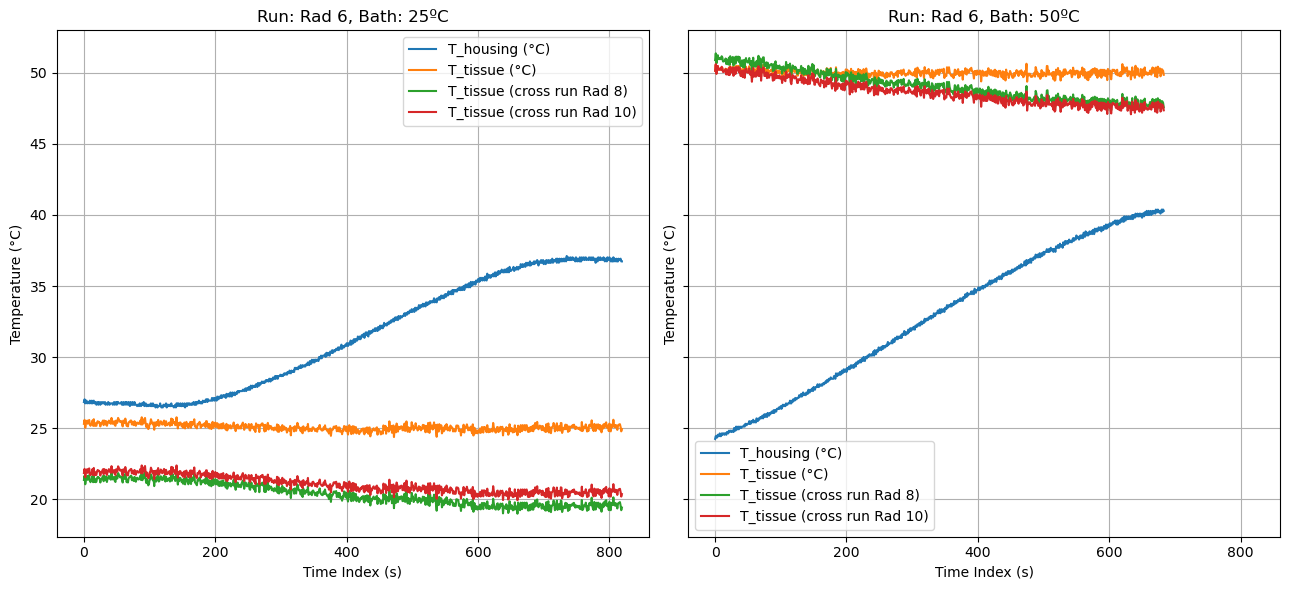

5.717130078598267
1.5203075925944667
2.71596969735392
0.3839801494494566


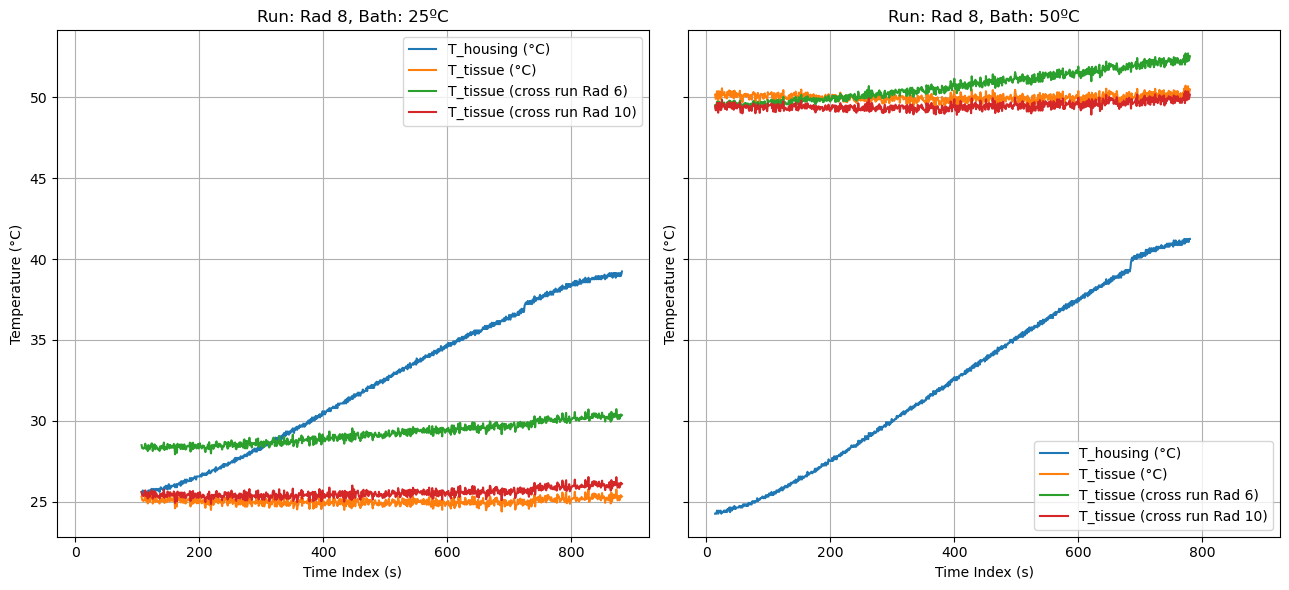

4.774566439910643
0.2363425123473668
3.03610500929733
1.4017433885209556


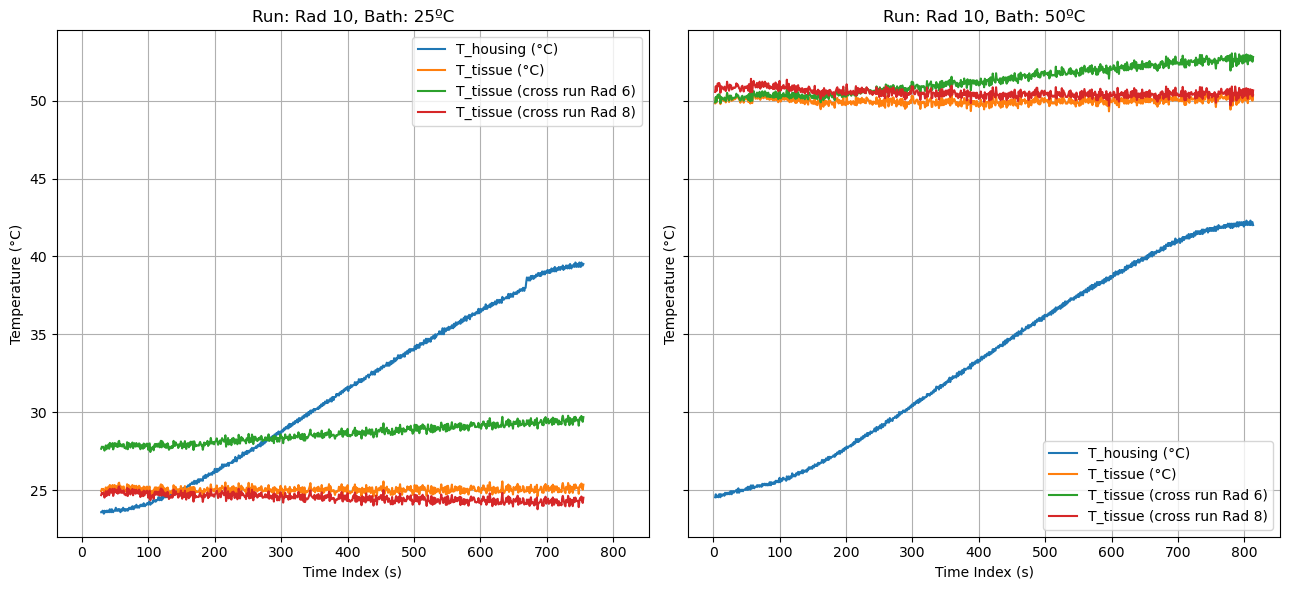

In [38]:
temp_vars = ['T_tissue', 'T_housing']
temp_labels = {
    # 'T_rad-tot': 'T_rad-tot (°C)',
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)'
}
for run in unique_runs:
    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)
    for idx, temp in enumerate([25, 50]):
        subset = all_X[(all_X['radiometer'] == run) & (all_X['temperature'] == temp)]
        V_housing_V = subset['V_housing']
        T_housing = T_housing_func(V_housing_V, HousingSlope, HousingOffset)
        axes[idx].plot(subset['time_index'], T_housing, label=temp_labels["T_housing"])
        V_rad_tot_V = subset['V_rad_tot'] / 1000
        T_tissue = T_rad_func(
            V_rad_tot_V, T_housing,
            rad_offset_params[run][0], rad_offset_params[run][1],
            rad_slope_params[run][0], rad_slope_params[run][1]
        )
        axes[idx].plot(subset['time_index'], T_tissue, label=temp_labels["T_tissue"])
        for other_run in [r for r in unique_runs if r != run]:
            T_tissue_cross = T_rad_func(
                V_rad_tot_V, T_housing,
                rad_offset_params[other_run][0], rad_offset_params[other_run][1],
                rad_slope_params[other_run][0], rad_slope_params[other_run][1]
            )
            print(max(T_tissue_cross - temp))
            axes[idx].plot(
                subset['time_index'],
                T_tissue_cross,
                label=f"T_tissue (cross run {other_run})"
            )
        handles, plot_labels = axes[idx].get_legend_handles_labels()
        by_label = dict(zip(plot_labels, handles))
        axes[idx].set_title(f"Run: {run}, Bath: {temp}ºC")
        axes[idx].set_xlabel("Time Index (s)")
        axes[idx].set_ylabel("Temperature (°C)")
        axes[idx].legend(by_label.values(), by_label.keys())
        axes[idx].grid(True)
    plt.tight_layout()
    plt.show()
